# Hand Segmentation



#### In this Project, We shall be following the steps below.
1. Library Importation
2. Load the Dataset
3. Dataset Exploration
4. Image Improvement (**Eroding**, *Dialation*, *Bluring*, *Resizing*, **ETC**)

## 1. Import all Libraries
**Import all the Needed Library**

In [3]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
import cv2
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting
import tensorflow as tf

import imgaug as aug #What is this for
import imgaug.augmenters as iaa
import pandas as pd
#to read text
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path

from IPython.core.display import HTML

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import glob
import h5py
import shutil
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf
#All Keras Dependencies
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
#from keras.optimizers import Adam,SGD, RMSprop
from tensorflow.keras.optimizers import RMSprop, Adam, SGD #Since Keras is now with TF
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from tensorflow.keras import layers


In [3]:
## Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

## 2. Input the path for the training and Validation

In [1]:
train_image_dir = '../Segmentation/Dataset/Train/'
val_image_dir = '../Segmentation/Datatset/Val/'

Explore the Classes, Different folders representing different classes

In [5]:
def datasetClasses(dataset):
    classes = dict()
    reverseclasses = dict()
    count = 1
    for j in os.listdir(dataset):
        if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
                classes[j] = count
                reverseclasses[count] = j
                count = count + 1
    return classes
train_classes = datasetClasses(train_image_dir)
dict_classes= train_classes
list_classes = list(dict_classes.keys()) 

In [6]:
dict_classes

{'A': 1, 'I': 2, 'L': 3, 'R': 4, 'V': 5}

**We have five different gestures (Images colections) saved into 5 folders.**

### 3. Exploring Dataset


In [7]:
train_image_dir = Path(train_image_dir)
val_image_dir = Path(val_image_dir)
def dataset_df(path, data):
    data_df = []
    for folder in os.listdir(path):
    # Define the path to the images
        imgs_path = path / folder
    
    # Get the list of all the images stored in that directory
        imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
        for img_name in imgs:
            data_df.append((str(img_name), train_classes[folder]))
    data_df = pd.DataFrame(data_df, columns=['image', 'class'], index=None)
    # shuffle the dataset 
    data_df = data_df.sample(frac=1.).reset_index(drop=True)
    print("Number of " +data+"  samples: ", len(data_df))
    return data_df
train_data_df = dataset_df(train_image_dir, "training")
train_data_df

Number of training  samples:  429


,image,class
0,..\Segmentation\Dataset\Train\R\IMG_9765.JPG,4
1,..\Segmentation\Dataset\Train\L\IMG_9444.JPG,3
2,..\Segmentation\Dataset\Train\I\IMG_9894.JPG,2
3,..\Segmentation\Dataset\Train\A\IMG_0212.JPG,1
4,..\Segmentation\Dataset\Train\A\IMG_0211.JPG,1
...,...,...
424,..\Segmentation\Dataset\Train\A\IMG_0042.JPG,1
425,..\Segmentation\Dataset\Train\L\IMG_9504.JPG,3
426,..\Segmentation\Dataset\Train\V\IMG_0003.JPG,5
427,..\Segmentation\Dataset\Train\R\IMG_0335.JPG,4


**Visualization**
Visualize the dataset for better undertanding

In [8]:
def Image_path_html(path):
    return '<img src="'+path+'"width="60">'
train_data_df.to_html(escape=False, formatters =dict(image=Image_path_html))
HTML(train_data_df.head(10).to_html(escape=False, formatters =dict(image=Image_path_html)))

,image,class
0,,4
1,,3
2,,2
3,,1
4,,1
5,,1
6,,3
7,,2
8,,5
9,,3


## 4. Image Enhancement (Optimization) 


Check the Histogram to understand the data 

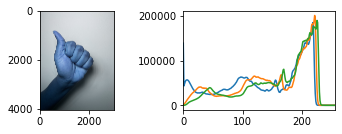

In [11]:
def hist_of_col(image):
    # Calculate histogram without mask
    hist1 = cv2.calcHist([image],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([image],[1],None,[256],[0,256])
    hist3 = cv2.calcHist([image],[2],None,[256],[0,256])
    plt.subplot(221), plt.imshow(img)
    plt.subplot(222), plt.plot(hist1), plt.plot(hist2),plt.plot(hist3)
    plt.xlim([0,256])
    plt.show()
path = '../Segmentation/DataSet/Train/A/IMG_0203.JPG'
img = cv2.imread(path)
hist_of_col(img)

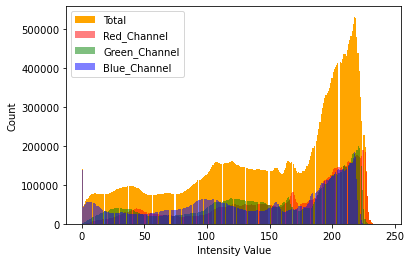

In [13]:
from skimage import io
import matplotlib.pyplot as plt
def hist_int_count(image):
    _ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
    _ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    _ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    _ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    _ = plt.xlabel('Intensity Value')
    _ = plt.ylabel('Count')
    _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.show()
    #Output: Figure-2
image = imread(path)
hist_int_count(image)

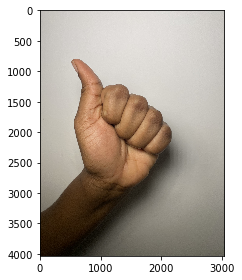

In [14]:
imshow(image)

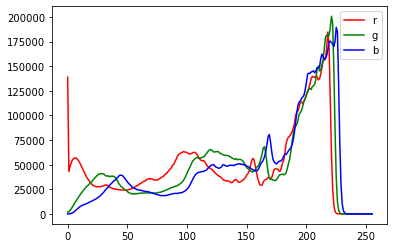

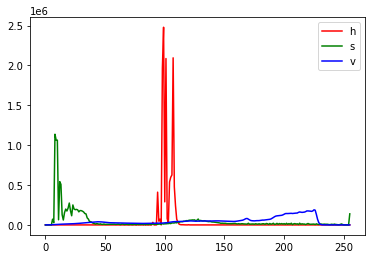

In [15]:
def color_space(img):
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
    hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
    hist_r = cv2.calcHist([r],[0],None,[256],[0,256])
    plt.plot(hist_r, color='r', label="r")
    plt.plot(hist_g, color='g', label="g")
    plt.plot(hist_b, color='b', label="b")
    plt.legend()
    plt.show() 
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv2.calcHist([h],[0],None,[256],[0,256])
    hist_s = cv2.calcHist([s],[0],None,[256],[0,256])
    hist_v = cv2.calcHist([v],[0],None,[256],[0,256])
    plt.plot(hist_h, color='r', label="h")
    plt.plot(hist_s, color='g', label="s")
    plt.plot(hist_v, color='b', label="v")
    plt.legend()
    plt.show()
    return hist_r,hist_g, hist_b, hist_h, hist_s, hist_v
r,g,b,h,s,v = color_space(image)

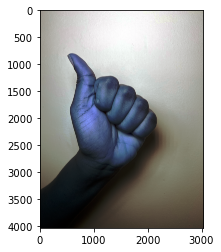

array([[[161, 154, 146],
        [156, 149, 139],
        [158, 151, 141],
        ...,
        [175, 170, 158],
        [175, 170, 158],
        [168, 164, 150]],

       [[156, 149, 139],
        [153, 147, 136],
        [155, 148, 137],
        ...,
        [177, 173, 161],
        [175, 170, 158],
        [175, 170, 158]],

       [[158, 151, 141],
        [158, 151, 141],
        [155, 148, 137],
        ...,
        [177, 173, 161],
        [168, 164, 150],
        [173, 168, 155]],

       ...,

       [[  0,   2,   4],
        [  7,   5,   6],
        [ 10,   6,   7],
        ...,
        [ 71,  56,  46],
        [ 70,  55,  45],
        [ 74,  58,  47]],

       [[  5,   4,   5],
        [  2,   3,   4],
        [  1,   2,   4],
        ...,
        [ 74,  58,  47],
        [ 62,  50,  41],
        [ 68,  54,  44]],

       [[  7,   5,   6],
        [  0,   0,   2],
        [  0,   0,   2],
        ...,
        [ 61,  50,  41],
        [ 62,  50,  41],
        [ 63,  51,  42]]

In [16]:
#Try Histogram of Equalization
def show_rgb_equalized(image):
    channels = cv2.split(image)
    eq_channels = []
    for ch, color in zip(channels, ['B', 'G', 'R']):
        eq_channels.append(cv2.equalizeHist(ch))

    eq_image = cv2.merge(eq_channels)
    eq_image = cv2.cvtColor(eq_image, cv2.COLOR_BGR2RGB)
    plt.imshow(eq_image)
    plt.show()
    return eq_image
show_rgb_equalized(image)

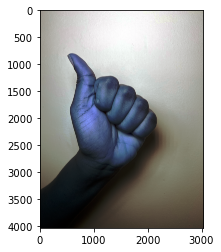

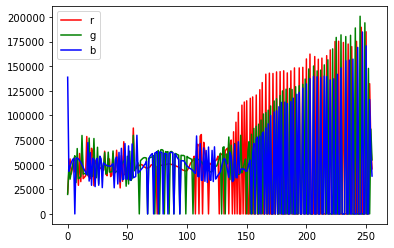

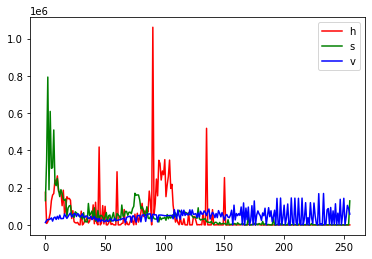

In [17]:
r,g,b,h,s,v = color_space(show_rgb_equalized(image))

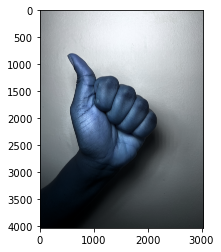

In [18]:
def show_hsv_equalized(image):
    H, S, V = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    eq_V = cv2.equalizeHist(V)
    eq_image = cv2.cvtColor(cv2.merge([H, S, eq_V]), cv2.COLOR_HSV2RGB)
    plt.imshow(eq_image)
    plt.show()
show_hsv_equalized(image)

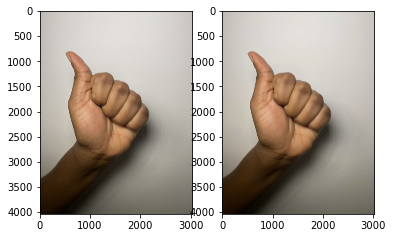

In [19]:
#Try to denoise a sample image and observe if it enhance the image quality. 
def fNMD_denoise(img):
    dst = cv2.fastNlMeansDenoisingColored(img,None,11,6,7,21)
    plt.subplot(121),plt.imshow(img)
    plt.subplot(122),plt.imshow(dst)
    plt.show()
def median_denoise(image):
    new_image = cv2.medianBlur(image, 5)
    plt.figure(figsize=(11,6))
    plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB)),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)),plt.title('Median Filter')
    plt.xticks([]), plt.yticks([])
    plt.show()
fNMD_denoise(image)

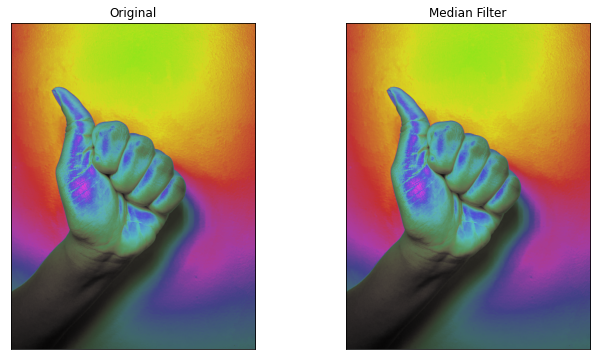

In [21]:
median_denoise(cv2.imread(path))

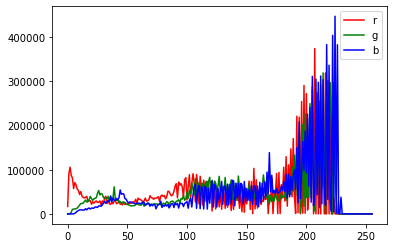

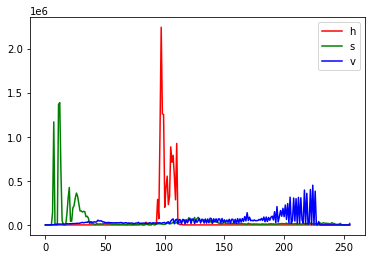

In [22]:
r,g,b,h,s,v = color_space(cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21))

**The Image is better off without equalization. And we can also see that it is easily segmented based on the HSv space**

## 5. Image Segmentation

### We worked on two different data type, one with blue background and the other with plane wall to see the results

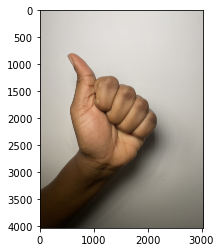

In [25]:
image_bb = cv2.imread(path)
image_hsv = cv2.cvtColor(image_bb, cv2.COLOR_BGR2HSV)
imager = cv2.cvtColor(image_bb, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_bb, cv2.COLOR_BGR2GRAY)
plt.imshow(imager)
plt.show()

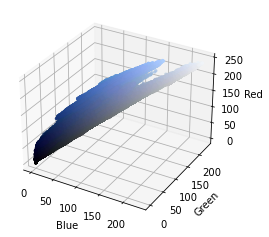

In [26]:
b, g, r = cv2.split(image_bb)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection ="3d")
pix_col = image_bb.reshape((np.shape(image_bb)[0]*np.shape(image_bb)[1], 3))
norm = colors.Normalize(vmin=-1., vmax =1.)
norm.autoscale(pix_col)
pix_col = norm(pix_col).tolist()
axis.scatter(b.flatten(), g.flatten(), r.flatten(), facecolors=pix_col, marker =".")
axis.set_xlabel("Blue")
axis.set_ylabel("Green")
axis.set_zlabel("Red")
plt.show()           

In the Hnad Segmentation function, we did the following.
1. Load the image with Cv2
2. COnvert the Image from BGR format to HSV
3. Set up the a function to get the hand color Range
4. Apply the mask
5. Combine the masks
6. Clean up the segmentationusing a blur

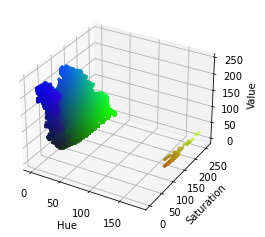

In [27]:
img_hsv = image_hsv
h, s, v = cv2.split(img_hsv)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection ="3d")
pix_col = img_hsv.reshape((np.shape(img_hsv)[0]*np.shape(img_hsv)[1], 3))
norm = colors.Normalize(vmin=-1., vmax =1.)
norm.autoscale(pix_col)
pix_col = norm(pix_col).tolist()
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pix_col, marker =".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [28]:
#A function to remove the background using the mask
def otus_img_msk(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])

In [29]:
def mask_builder(filename,hl,hh,sl,sh,vl,vh):
        #load image, convert to hsv
        bgr = cv2.imread(filename)
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        #set lower and upper bounds of range according to arguements
        lower_bound = np.array([hl,sl,vl],dtype=np.uint8)
        upper_bound = np.array([hh,sh,vh],dtype=np.uint8)
        return cv2.inRange(hsv, lower_bound,upper_bound)

In [ ]:
mask2 = mask_builder(path, 20,255, 0,255, 60,255)
plt.imshow(mask2)
plt.show()

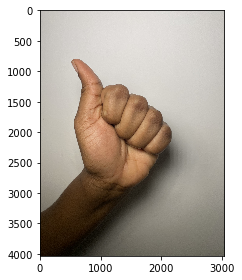

In [30]:
hand = imread(path)
imshow(hand)

In [31]:
def thresholder(image):
    th_values = np.linspace(0, 1, 11)
    fig, axis = plt.subplots(2, 5, figsize=(15,8))
    gray = rgb2gray(image)
    for th, ax in zip(th_values, axis.flatten()):
        binarized = gray < th
        ax.imshow(binarized)
        ax.set_title('$Threshold = %.2f$' % th)

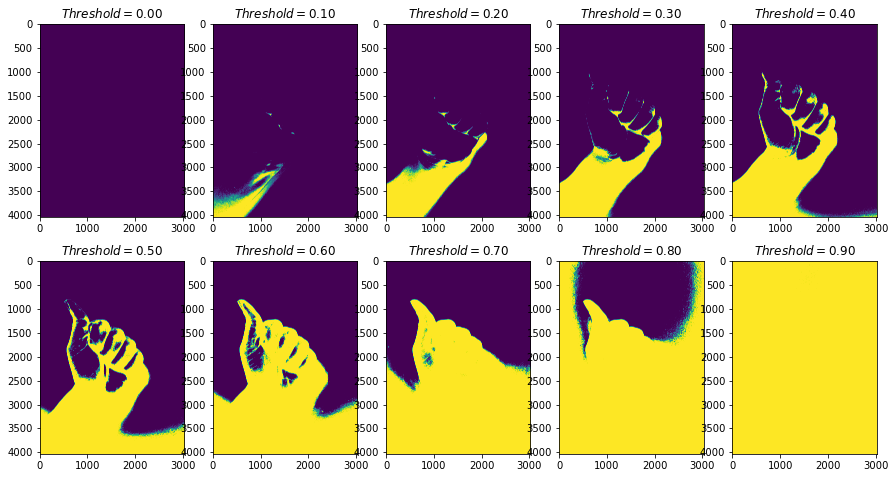

In [32]:
thresholder(hand)

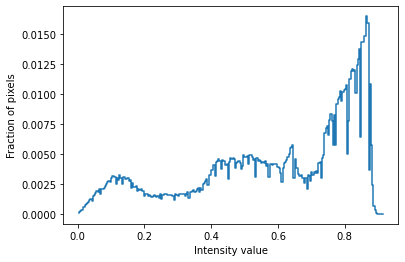

In [33]:
 gray = rgb2gray(hand)
freq, bins = histogram(gray)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('Intensity value')
plt.ylabel('Fraction of pixels');

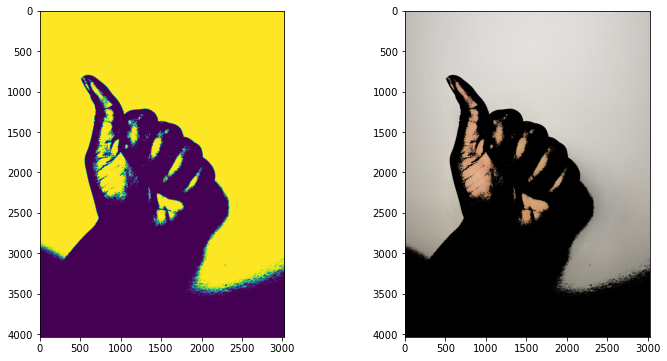

In [34]:
def thresh_segment(img, thresh_type):
    gray = rgb2gray(img)
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    thresh = thresh_type
    thresh_rule  = gray > thresh
    ax[0].imshow(thresh_rule)
    filtered = otus_img_msk(hand, thresh_rule)
    ax[1].imshow(filtered)
image = hand
otsu_thresh = threshold_otsu(gray) 
thresh_segment(img, otsu_thresh)

In [35]:
yen_thresh = threshold_yen(gray) 
thresh_segment(img, yen_thresh)

NameError: name 'threshold_yen' is not defined

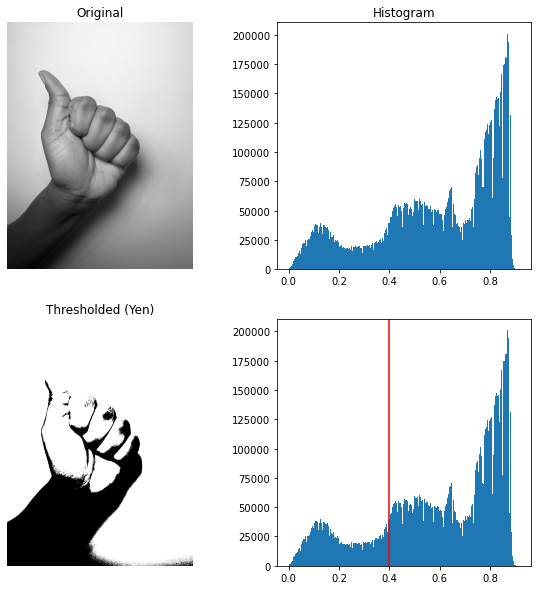

In [67]:
image = gray

thresh_yen = threshold_yen(image)
binary_min = image > thresh_yen

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Yen)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_yen, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

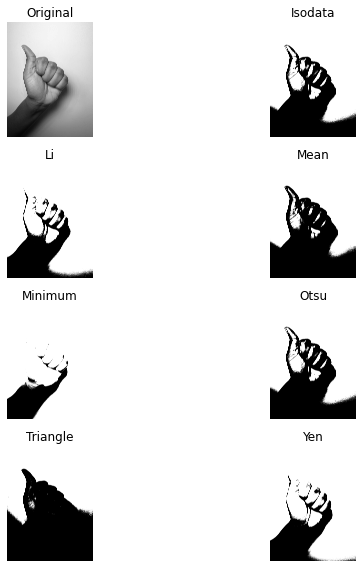

In [68]:
from skimage import data
from skimage.filters import try_all_threshold

img = gray

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [56]:
print(type(chico_otsu))
print(chico_otsu.shape)

<class 'numpy.ndarray'>
(4032, 3024)


Text(0.5, 1.0, 'Segmented')

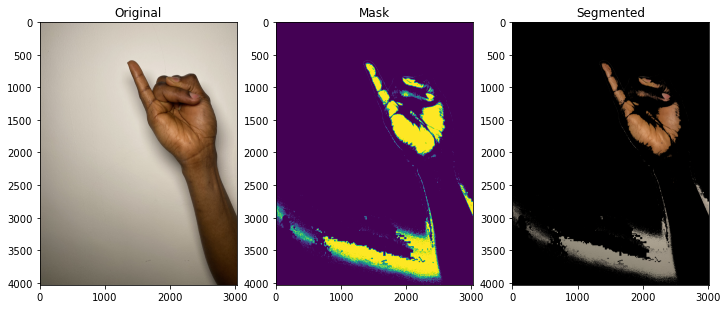

In [97]:
import cv2
hsv = cv2.cvtColor(hand, cv2.COLOR_BGR2HSV)
     
# Threshold of blue in HSV space
lower_blue = np.array([60, 38, 138])
upper_blue = np.array([120, 255, 255])
 
# preparing the mask to overlay
mask = cv2.inRange(hsv, lower_blue, upper_blue)
     
# The black region in the mask has the value of 0,
# so when multiplied with original image removes all non-blue regions
result = cv2.bitwise_and(hand, hand, mask = mask)
fig, ax = plt.subplots(1, 3, figsize=(12,6))
ax[0].imshow(hand)
ax[0].set_title('Original')
ax[1].imshow(mask)
ax[1].set_title('Mask')
ax[2].imshow(result)
ax[2].set_title('Segmented')


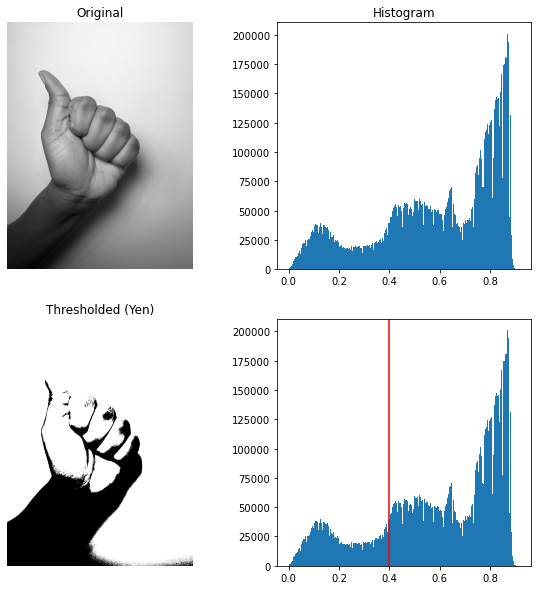

In [70]:
from skimage.filters import threshold_yen
image = gray

thresh_yen = threshold_yen(image)
binary_min = image > thresh_yen

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (Yen)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_yen, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

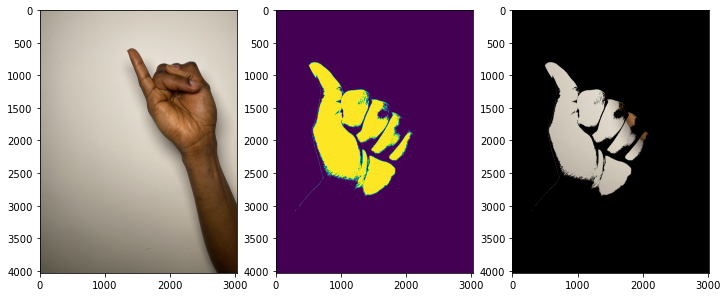

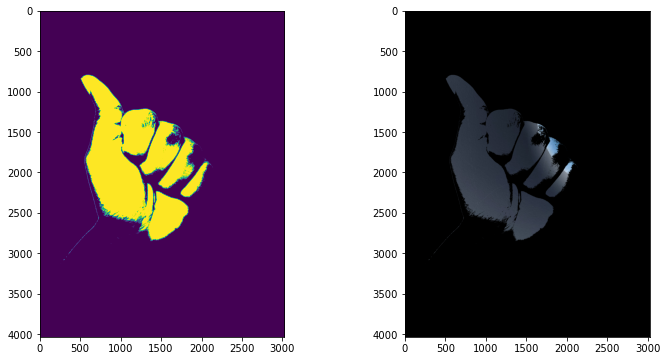

In [96]:
result = cv2.bitwise_and(hand, hand, mask = mask)
fig, ax = plt.subplots(1, 3, figsize=(12,6))
ax[0].imshow(hand)

ax[1].imshow(mask)
ax[2].imshow(result)


fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(mask)
filtered = otus_img_msk(hand, mask)
ax[1].imshow(filtered)

In [39]:
image = imread(path)
image_hsv = rgb2hsv(image)


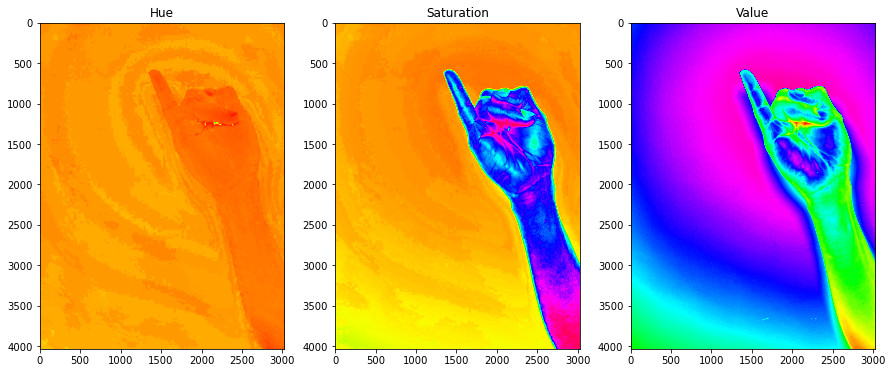

In [40]:
def hand_cmap(hsv_image):
   
    fig, ax = plt.subplots(1, 3, figsize=(15,6))
    ax[0].imshow(hsv_image[:,:,0], cmap='hsv')
    ax[0].set_title('Hue')
    ax[1].imshow(hsv_image[:,:,1], cmap='hsv')
    ax[1].set_title('Saturation')
    ax[2].imshow(hsv_image[:,:,2], cmap='hsv')
    ax[2].set_title('Value');
hand = imread("../Segmentation/DataSet/Val/I/IMG_9271.jpg")
hand_hsv = rgb2hsv(hand)
hand_cmap(hand_hsv)

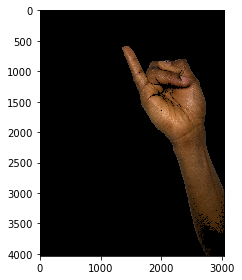

In [41]:
def hsv_seperation(hand,hsv_image, low_hue, high_hue, low_sat, high_sat, low_val, high_val):
    #figure, ax = plt.subplots(1,3, figsize=(12,6))
    hsv_hue = hsv_image[:,:,0] 
    hsv_sat = hsv_image[:,:,1]
    hsv_val = hsv_image[:,:,2]
    binarized_hsv = ((hsv_hue < high_hue) & (hsv_hue > low_hue) & 
                 (hsv_sat > low_sat)  & (hsv_sat < high_sat) & (hsv_val > low_val)  & (hsv_val < high_val))
    opened = area_opening(binarized_hsv, 5000)
    #ax[0].imshow(hand)
    #ax[0].set_title('Original')
    #ax[1].imshow(binarized_hsv)
    #ax[1].set_title('Mask')
    #ax[2].imshow(otus_img_msk(hand, opened))
    #ax[2].set_title('Segmented')
    
    segment = otus_img_msk(hand, opened)
    return segment

d = hsv_seperation(hand, hand_hsv, 0.001, 0.4, 0.3, 0.90, 0.01, 0.90 )
imshow(d)
#hsv_seperation(hand, hand_hsv, 0.001, 0.4, 0.3, 0.90, 0.01, 0.90 )

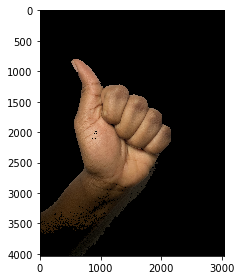

In [42]:
e = hsv_seperation(image, image_hsv, 0.001, 0.4, 0.3, 0.90, 0.01, 0.90 )
imshow(e)

In [43]:
seg = "s"
data_paths = [train_image_dir, val_image_dir]
for data in data_paths:
        
        images = []

        print("Loading {}".format(data))
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(data):
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(data, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(data, folder), file)
                
                # Open and resize the img
                image = imread(img_path)
                image_hsv = rgb2hsv(image)
                imager = hsv_seperation(image, image_hsv, 0.001, 0.4, 0.3, 0.90, 0.01, 0.90 )
                cv2.imwrite(img_path + seg +'.jpg', imager) 

  0%|          | 0/81 [00:00<?, ?it/s]

Loading ..\Segmentation\Dataset\Train


  1%|          | 1/81 [00:35<47:20, 35.50s/it]


KeyboardInterrupt: 